# Прикладная статистика и анализ данных
## Задание 2.2


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Теоретические задачи необходимо оформить в latex/markdown и прислать `pdf` или же прислать фотку в правильной ориентации рукописного решения, где **все четко видно**.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.
* В каждой задаче не забывайте делать **пояснения и выводы**.
* Код, уже данный в задании, тоже можно менять.

**Баллы за задание:**

* Задача 1 — 8 баллов

----


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 15)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.model_selection import GridSearchCV

---

## Задача 1

В файле `houses_train.csv` представлен набор данных про квартиры в городе Сиэтл, штат Вашингтон. Задача — предсказать цену на жилье по имеющимся данным.

Данные имеют следующие столбцы.

- `id` — идентификационный номер жилья
- `date` — дата продажи дома
- `price` — цена
- `bedrooms` — количество спален
- `bathrooms` — количество ванных комнат, где .5 означает комнату с туалетом, но без душа
- `sqft_living` — площадь жилья
- `sqft_lot` — площадь участка
- `floors` — количество этажей
- `waterfront` — видна ли набережная
- `view` — насколько хороший вид
- `condition` — индекс от 1 от 5, отвечающий за состояние квартиры
- `grade` — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 — средний уровень, 11-13 — высокий.
- `sqft_above` — жилая площадь над уровнем земли
- `sqft_basement` — жилая площадь под уровнем земли
- `yr_built` — год постройки жилья
- `yr_renovated` — год последней реконструкции жилья
- `zipcode` — почтовый индекс
- `lat` — широта
- `long` — долгота
- `sqft_living15` — средняя площадь жилья ближайших 15-и соседей
- `sqft_lot15` — средняя площадь участка ближайших 15-и соседей

Как видите, признаки в этом датасете есть разных видов: вещественные, бинарные, категориальные. Есть параметры географические, есть временные. Задание заключается в том, чтобы по этим данным построить модель на основе **решающего дерева** и выбрать для неё наилучший набор признаков.

Считайте данные в таблицу. Разделите данные на обучающую и валидационную части.

Заметим, что всякая генерация признаков в данной строчке, требующаяся в этой задаче, кроме тех, которые генерируются с помощью `MeanEncoding`, зависит только от текущих строчек. Это значит, что тренировочная и валидационная выборка не будут влиять друг на друга при такой генерации признаков. Поэтому логично сначала сгенерировать все признаки, кроме тех, которые генерируются с помощью `MeanEncoding`, потом разделить выборку, а потом сгенерировать признаки, которые генерируются с помощью `MeanEncoding`. Еще легко понять, что от `id` ничего не зависит, поэтому это бесполезная колонка, и ее следует удалить.

In [4]:
df = pd.read_csv('houses_train.csv')
df.drop('id', axis=1, inplace=True)
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20151013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20151209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20151209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,20160218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,20150627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,20160126T000000,429000.0,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
15622,20151014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15623,20150521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15624,20160223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


### Генерация признаков

Вспомните советы про признаки с типом "время" и сгенерируйте признак, производный от (`yr_built` или `yr_renovated`) и `date`.

Заметим, что точной даты постройки и реставрации нет (есть только год), поэтому, я думаю, не имеет смысла оставлять полную дату, достаточно ограничиться годом (заменить `date` на `yr`). Можно также сгенерировать несколько признаков: `yrs_from_built` (сколько лет прошло с постройки до продажи), `yrs_from_renowated` (сколько лет прошло с реставрации до продажи), `was_renovated` (был ли реставрирован дом). Сгенерируем их все. 

In [5]:
from datetime import datetime

In [6]:
yrs = []
for date in df['date']:
    yrs.append(datetime.strptime(date, '%Y%m%dT%H%M%S').year)
    
min(yrs), max(yrs)

(2015, 2016)

In [7]:
df['yr'] = yrs
df.drop('date', axis=1, inplace=True)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2015
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2015
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2015
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2016
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,429000.0,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230,2016
15622,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,2015
15623,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,2015
15624,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,2016


In [8]:
df['yrs_from_built'] = df['yr'] - df['yr_built']
df['yrs_from_renovated'] = df['yr'] - df['yr_renovated']
# будем считать, что если дом не реставрировался, то время с его реставрации равно времени с его постройки
df['yrs_from_renovated'][df['yr_renovated'] == 0] = df['yr'] - df['yr_built']
df['was_renovated'] = 0
df['was_renovated'][df['yr_renovated'] != 0] = 1
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr,yrs_from_built,yrs_from_renovated,was_renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,1340,5650,2015,60,60,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1991,98125,47.7210,-122.319,1690,7639,2015,64,24,1
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,0,98136,47.5208,-122.393,1360,5000,2015,50,50,0
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,1800,7503,2016,29,29,0
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,0,98003,47.3097,-122.327,2238,6819,2015,20,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,429000.0,3,2.00,1490,1126,3.0,0,0,3,8,...,0,98144,47.5699,-122.288,1400,1230,2016,2,2,0
15622,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,0,98056,47.5137,-122.167,2520,6023,2015,1,1,0
15623,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,0,98103,47.6993,-122.346,1530,1509,2015,6,6,0
15624,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,0,98146,47.5107,-122.362,1830,7200,2016,2,2,0


Найдите точку в центре города Сиэтл. Вычислите новый признак "расстояние до центра". Также поверните координаты на $45$ градусов.

Перенесем также центр в центр города Сиэтл (заменим данные широту и долготу на эквивалентные с точки зрения дерева широту и долготу относительно цетра Сиэтла, т. е. `lat_rel_center` и `long_rel_center`), так как логичнее всего делать преобразования относительно центра города. 

In [9]:
lat_center, long_center = 47.607968, -122.328461

df['lat_rel_center'] = df['lat'] - lat_center
df['long_rel_center'] = df['long'] - long_center
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,yr,yrs_from_built,yrs_from_renovated,was_renovated,lat_rel_center,long_rel_center
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,47.5112,-122.257,1340,5650,2015,60,60,0,-0.096768,0.071461
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,47.7210,-122.319,1690,7639,2015,64,24,1,0.113032,0.009461
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,47.5208,-122.393,1360,5000,2015,50,50,0,-0.087168,-0.064539
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,47.6168,-122.045,1800,7503,2016,29,29,0,0.008832,0.283461
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,47.3097,-122.327,2238,6819,2015,20,20,0,-0.298268,0.001461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,429000.0,3,2.00,1490,1126,3.0,0,0,3,8,...,47.5699,-122.288,1400,1230,2016,2,2,0,-0.038068,0.040461
15622,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,47.5137,-122.167,2520,6023,2015,1,1,0,-0.094268,0.161461
15623,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,47.6993,-122.346,1530,1509,2015,6,6,0,0.091332,-0.017539
15624,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,47.5107,-122.362,1830,7200,2016,2,2,0,-0.097268,-0.033539


Теперь рассчитаем расстояние до центра.

In [10]:
def count_distance_from_center(lat_from_center, long_from_center, lat):
    a_on_one_deg = 111.16
    b_on_one_deg = 111.3
    a = long_from_center * a_on_one_deg
    b = lat_from_center * b_on_one_deg * np.cos(lat)
    dist = np.sqrt(a ** 2 + b ** 2)
    return dist

In [11]:
dists = count_distance_from_center(df['lat_rel_center'], df['long_rel_center'], df['lat'])
df['dist_from_center'] = dists
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,yr,yrs_from_built,yrs_from_renovated,was_renovated,lat_rel_center,long_rel_center,dist_from_center
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,-122.257,1340,5650,2015,60,60,0,-0.096768,0.071461,12.749578
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,-122.319,1690,7639,2015,64,24,1,0.113032,0.009461,10.456609
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,-122.393,1360,5000,2015,50,50,0,-0.087168,-0.064539,11.468551
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,-122.045,1800,7503,2016,29,29,0,0.008832,0.283461,31.521423
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,-122.327,2238,6819,2015,20,20,0,-0.298268,0.001461,32.626205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,429000.0,3,2.00,1490,1126,3.0,0,0,3,8,...,-122.288,1400,1230,2016,2,2,0,-0.038068,0.040461,5.902561
15622,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,-122.167,2520,6023,2015,1,1,0,-0.094268,0.161461,20.403836
15623,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,-122.346,1530,1509,2015,6,6,0,0.091332,-0.017539,8.748345
15624,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,-122.362,1830,7200,2016,2,2,0,-0.097268,-0.033539,10.696806


Теперь повернем координаты на 45 градусов.

In [12]:
def rotate(lat, long, angle):
    rot_lat = lat * np.cos(angle) - long * np.sin(angle)
    rot_long = lat * np.sin(angle) + long * np.cos(angle)
    return rot_lat, rot_long

In [13]:
df['rot_lat'], df['rot_long'] = rotate(df['lat_rel_center'], df['long_rel_center'], np.pi / 4)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,yr,yrs_from_built,yrs_from_renovated,was_renovated,lat_rel_center,long_rel_center,dist_from_center,rot_lat,rot_long
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,5650,2015,60,60,0,-0.096768,0.071461,12.749578,-0.118956,-0.017895
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,7639,2015,64,24,1,0.113032,0.009461,10.456609,0.073236,0.086616
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,5000,2015,50,50,0,-0.087168,-0.064539,11.468551,-0.016001,-0.107273
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,7503,2016,29,29,0,0.008832,0.283461,31.521423,-0.194192,0.206682
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,6819,2015,20,20,0,-0.298268,0.001461,32.626205,-0.211940,-0.209874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,429000.0,3,2.00,1490,1126,3.0,0,0,3,8,...,1230,2016,2,2,0,-0.038068,0.040461,5.902561,-0.055528,0.001692
15622,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,6023,2015,1,1,0,-0.094268,0.161461,20.403836,-0.180828,0.047513
15623,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,1509,2015,6,6,0,0.091332,-0.017539,8.748345,0.076983,0.052180
15624,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,7200,2016,2,2,0,-0.097268,-0.033539,10.696806,-0.045063,-0.092495


Наконец, удалим столбцы `lat` и `long`.

In [14]:
df.drop('lat', axis=1, inplace=True)
df.drop('long', axis=1, inplace=True)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,yr,yrs_from_built,yrs_from_renovated,was_renovated,lat_rel_center,long_rel_center,dist_from_center,rot_lat,rot_long
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,5650,2015,60,60,0,-0.096768,0.071461,12.749578,-0.118956,-0.017895
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,7639,2015,64,24,1,0.113032,0.009461,10.456609,0.073236,0.086616
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,5000,2015,50,50,0,-0.087168,-0.064539,11.468551,-0.016001,-0.107273
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,7503,2016,29,29,0,0.008832,0.283461,31.521423,-0.194192,0.206682
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,6819,2015,20,20,0,-0.298268,0.001461,32.626205,-0.211940,-0.209874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,429000.0,3,2.00,1490,1126,3.0,0,0,3,8,...,1230,2016,2,2,0,-0.038068,0.040461,5.902561,-0.055528,0.001692
15622,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,6023,2015,1,1,0,-0.094268,0.161461,20.403836,-0.180828,0.047513
15623,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,1509,2015,6,6,0,0.091332,-0.017539,8.748345,0.076983,0.052180
15624,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,7200,2016,2,2,0,-0.097268,-0.033539,10.696806,-0.045063,-0.092495


Теперь разделим выборку.

In [15]:
X_train, X_valid, Y_train, Y_valid = train_test_split(df.loc[:, df.columns != 'price'], df['price'], random_state=666)
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,sqft_lot15,yr,yrs_from_built,yrs_from_renovated,was_renovated,lat_rel_center,long_rel_center,dist_from_center,rot_lat,rot_long
1610,3,1.75,1720,12540,1.0,0,0,4,7,1720,...,11850,2015,59,59,0,-0.038068,0.151461,17.264876,-0.134017,0.080181
8473,3,2.25,1560,43350,1.0,0,3,4,7,1570,...,220849,2015,48,48,0,-0.370268,0.312461,53.691916,-0.482762,-0.040876
10341,3,1.00,1150,7080,1.0,0,0,3,7,1150,...,7921,2015,63,63,0,0.102632,0.040461,10.522318,0.043962,0.101182
8445,3,1.00,1180,9000,1.0,0,0,4,7,1180,...,8316,2015,45,45,0,-0.217968,0.162461,29.562992,-0.269004,-0.039249
179,4,2.50,3650,8354,1.0,1,4,3,9,1830,...,18841,2015,15,15,0,0.025832,0.256461,28.618431,-0.163079,0.199611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,3,1.00,1140,7560,1.0,0,0,4,6,1140,...,7560,2015,57,57,0,-0.145568,0.143461,22.087526,-0.204374,-0.001490
10142,4,1.50,1360,8100,1.5,0,0,3,7,1360,...,8100,2015,53,53,0,-0.114868,0.023461,12.205152,-0.097813,-0.064635
7597,4,2.50,2310,14023,2.0,0,0,3,9,2310,...,14007,2015,24,24,0,0.127132,0.364461,42.138164,-0.167817,0.347609
10114,2,1.00,1300,11400,1.0,0,0,3,7,1300,...,9750,2015,54,54,0,-0.262068,0.029461,28.640139,-0.206142,-0.164478


Найдите какой-нибудь категориальный признак. Порассуждайте на тему того, стоит ли применять к нему MeanEncoding. Если нужно, реализуйте его и примените.

Возьмем признак `zipcode` (почтовый индекс). Логично, что средняя цена дома зависит от почтового индекса, так как почтовый индекс определяет район города, поэтому применим для выбранного признака "наивный" `MeanEncoding`.

In [16]:
def mean_encoding(df, feature_name, target_name):
    mean_encoded = df.groupby([feature_name])[target_name].mean().to_dict()
    new_col_str = feature_name + '_mean'
    df[new_col_str] = df[feature_name].map(mean_encoded)
    return mean_encoded

In [17]:
df_train = X_train.copy()
df_train['price'] = Y_train.to_numpy()
df_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr,yrs_from_built,yrs_from_renovated,was_renovated,lat_rel_center,long_rel_center,dist_from_center,rot_lat,rot_long,price
1610,3,1.75,1720,12540,1.0,0,0,4,7,1720,...,2015,59,59,0,-0.038068,0.151461,17.264876,-0.134017,0.080181,490000.0
8473,3,2.25,1560,43350,1.0,0,3,4,7,1570,...,2015,48,48,0,-0.370268,0.312461,53.691916,-0.482762,-0.040876,325000.0
10341,3,1.00,1150,7080,1.0,0,0,3,7,1150,...,2015,63,63,0,0.102632,0.040461,10.522318,0.043962,0.101182,522000.0
8445,3,1.00,1180,9000,1.0,0,0,4,7,1180,...,2015,45,45,0,-0.217968,0.162461,29.562992,-0.269004,-0.039249,215000.0
179,4,2.50,3650,8354,1.0,1,4,3,9,1830,...,2015,15,15,0,0.025832,0.256461,28.618431,-0.163079,0.199611,2400000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,3,1.00,1140,7560,1.0,0,0,4,6,1140,...,2015,57,57,0,-0.145568,0.143461,22.087526,-0.204374,-0.001490,218000.0
10142,4,1.50,1360,8100,1.5,0,0,3,7,1360,...,2015,53,53,0,-0.114868,0.023461,12.205152,-0.097813,-0.064635,201000.0
7597,4,2.50,2310,14023,2.0,0,0,3,9,2310,...,2015,24,24,0,0.127132,0.364461,42.138164,-0.167817,0.347609,470000.0
10114,2,1.00,1300,11400,1.0,0,0,3,7,1300,...,2015,54,54,0,-0.262068,0.029461,28.640139,-0.206142,-0.164478,170000.0


In [18]:
mean_encoded = mean_encoding(df_train, 'zipcode', 'price')
df_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yrs_from_built,yrs_from_renovated,was_renovated,lat_rel_center,long_rel_center,dist_from_center,rot_lat,rot_long,price,zipcode_mean
1610,3,1.75,1720,12540,1.0,0,0,4,7,1720,...,59,59,0,-0.038068,0.151461,17.264876,-0.134017,0.080181,490000.0,8.325759e+05
8473,3,2.25,1560,43350,1.0,0,3,4,7,1570,...,48,48,0,-0.370268,0.312461,53.691916,-0.482762,-0.040876,325000.0,3.136912e+05
10341,3,1.00,1150,7080,1.0,0,0,3,7,1150,...,63,63,0,0.102632,0.040461,10.522318,0.043962,0.101182,522000.0,4.773248e+05
8445,3,1.00,1180,9000,1.0,0,0,4,7,1180,...,45,45,0,-0.217968,0.162461,29.562992,-0.269004,-0.039249,215000.0,3.001453e+05
179,4,2.50,3650,8354,1.0,1,4,3,9,1830,...,15,15,0,0.025832,0.256461,28.618431,-0.163079,0.199611,2400000.0,6.909022e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,3,1.00,1140,7560,1.0,0,0,4,6,1140,...,57,57,0,-0.145568,0.143461,22.087526,-0.204374,-0.001490,218000.0,3.465998e+05
10142,4,1.50,1360,8100,1.5,0,0,3,7,1360,...,53,53,0,-0.114868,0.023461,12.205152,-0.097813,-0.064635,201000.0,2.429130e+05
7597,4,2.50,2310,14023,2.0,0,0,3,9,2310,...,24,24,0,0.127132,0.364461,42.138164,-0.167817,0.347609,470000.0,4.140560e+05
10114,2,1.00,1300,11400,1.0,0,0,3,7,1300,...,54,54,0,-0.262068,0.029461,28.640139,-0.206142,-0.164478,170000.0,3.022029e+05


In [388]:
X_train['zipcode_mean'] = df_train['zipcode_mean']
X_valid['zipcode_mean'] = X_valid['zipcode'].map(mean_encoded)
X_train.drop('zipcode', axis=1, inplace=True)
X_valid.drop('zipcode', axis=1, inplace=True)
X_train.shape, X_valid.shape

((11719, 25), (3907, 25))

Постройте распределения вещественных признаков на обучающей выборке. Какие преобразования можно с ними сделать, чтобы сделать распределение ближе к нормальному? Нужно ли это для деревьев?

In [389]:
real_features = X_train.columns.to_list()
categorial_features = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 
                      'was_renovated']
for cat_feature in categorial_features:
    real_features.remove(cat_feature)
    
real_features

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'sqft_living15',
 'sqft_lot15',
 'yr',
 'yrs_from_built',
 'yrs_from_renovated',
 'lat_rel_center',
 'long_rel_center',
 'dist_from_center',
 'rot_lat',
 'rot_long',
 'zipcode_mean']

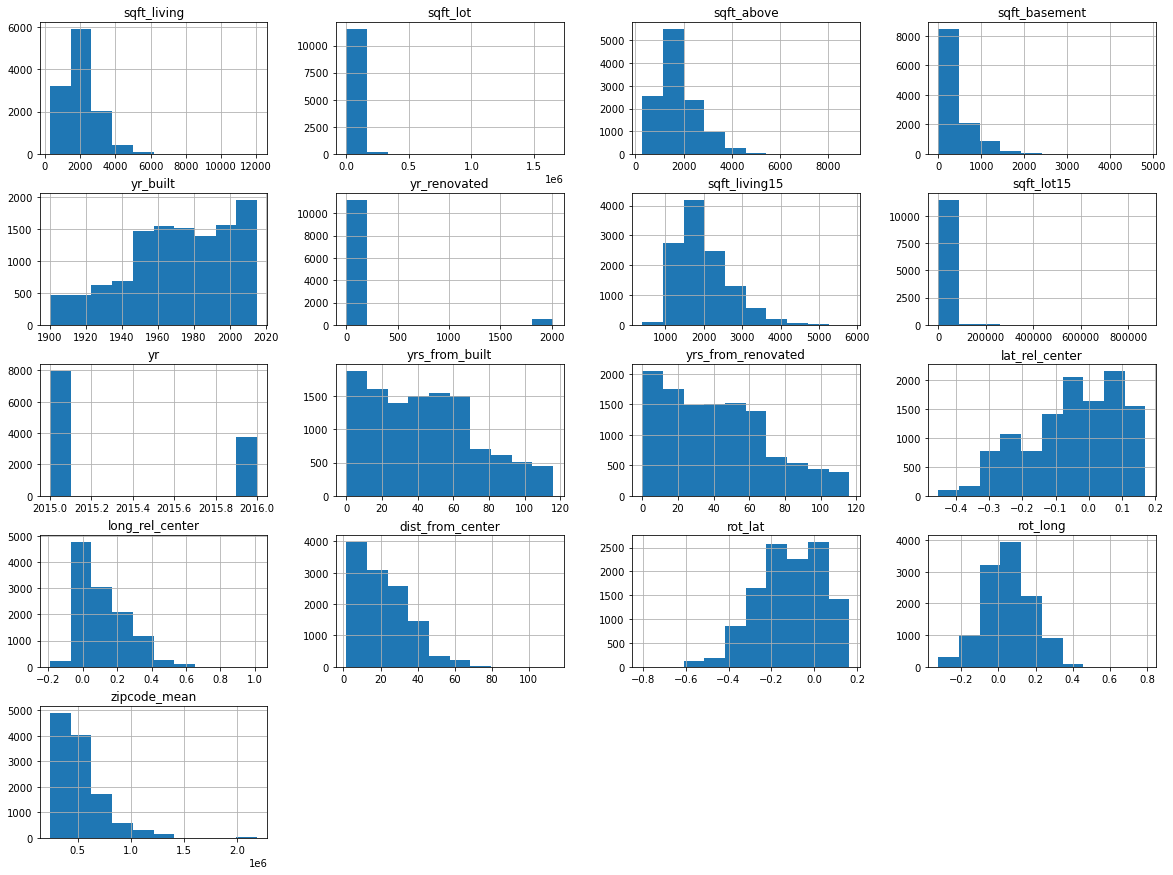

In [390]:
h = X_train[real_features].hist()

Единственный количественный признак, который сразу похож на "нормальный" &mdash; это признак `rot_long`. Остальные можно было попробовать привести к более "нормальным", взяв, например, корень или логарифм от признаков, однако для дерева нормальность признаков не нужна, так как дерево делит элементы, исходя из соображений порядка, то есть, для него не важно распределение признаков.

### Отбор признаков

В этой части задания вам необходимо сравнить различные методы отбора признаков:

* Отбор по `feature_importances`
* Отбор при помощи метода <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest">SelectKBest</a>
* Отбор с помощью метода Add-Del

Сначала подберем параметры дерева. Посмотрим на график зависимости метрики от количества деревьев при дефолтных остальных параметрах.

In [400]:
def cum_metric(model, metric, x_test, y_test):
    ''' 
    Считает значение метрики в зависимости от количества деревьев в модели
    
    Мы не обучаем много лесов с разным кол-вом деревьев, 
    а смотрим на один обученный лес. Предсказание леса из k деревьев — 
    усредненное предсказание первых k деревьев из нашего леса.

    Параметры.
    1) model — модель случайного леса,
    2) metric — вычисляемая метрика,
    3) x_test — данные тестовой выборки,
    4) y_test — метки тестовой выборки.
    '''
    
    predictions_by_estimators = [est.predict(x_test) for est in model.estimators_]
    cumpred = np.array(predictions_by_estimators).cumsum(axis=0) \
              / (np.arange(len(predictions_by_estimators)) + 1)[:, np.newaxis]
    cumacc = [metric(y_test, pred) for pred in cumpred]
    return np.array(cumacc)

100%|██████████| 50/50 [08:52<00:00, 10.65s/it]


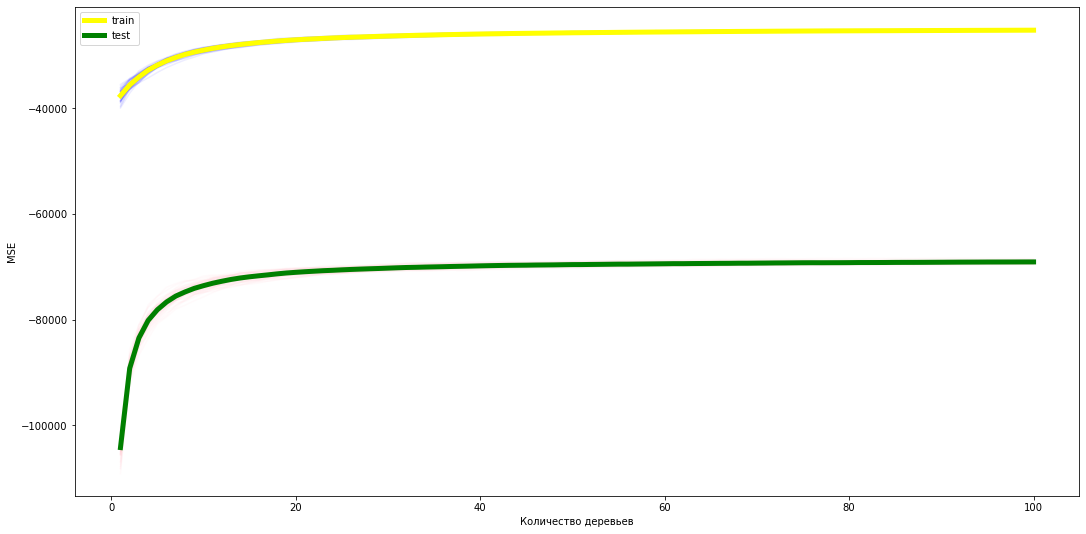

Wall time: 8min 52s


In [403]:
%%time

n_iterations = 50
n_estimators = 100
scores_train = np.zeros((n_iterations, n_estimators))
scores_test = np.zeros((n_iterations, n_estimators))
estrimator_range = np.arange(n_estimators) + 1

plt.figure(figsize=(18, 9))

for i in tqdm(range(n_iterations)):
    rf = RandomForestRegressor(n_estimators=n_estimators).fit(X_train, Y_train)
    scores_train[i] = cum_metric(rf, mae, X_train, Y_train)
    scores_test[i] = cum_metric(rf, mae, X_valid, Y_valid)
    plt.plot(estrimator_range, scores_train[i], color='blue', alpha=0.07)
    plt.plot(estrimator_range, scores_test[i], color='pink', alpha=0.07)

plt.plot(estrimator_range, scores_train.mean(axis=0), 
         lw=5, color='yellow', label='train')
plt.plot(estrimator_range, scores_test.mean(axis=0), 
         lw=5, color='green', label='test')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.legend()
plt.show()

Из теории мы знаем, что с ростом числа деревьев метрика почти всегда становится лучше, но мы можем оценить число деревьев из сооображения, что метрика почти не меняется. Видно, что после 40 деревьев метрика почти не меняется, поэтому будем считать, что оптимальный параметр: `n_estimators` = 40.

In [410]:
tree_gridsearch = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_estimators=40),
    param_grid={
        'max_depth': [3, 5, 10, None], 
        'min_samples_leaf': [1, 2, 5, 10], 
        'min_samples_split': [2, 5, 10]
    }, verbose=2
)

In [411]:
tree_gridsearch.fit(X_train, Y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.6s
[CV] END max_depth=3, min_samples_l

[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5; total time=   1.0s
[CV] 

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split

GridSearchCV(estimator=RandomForestRegressor(n_estimators=40, random_state=42),
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [412]:
print(tree_gridsearch.best_params_)

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


Зафиксируем лучшие параметры.

**Метод Add-Del**

Чтобы понять нужное количество признаков $K$, используем алгоритм Add-Del. Будем добавлять лучший признак до тех пор, пока это улучшает качество на валидации. Затем будем убирать самый мешающий, пока есть улучшения. Будем делать так, пока процесс не сойдётся. Реализуем функции для этого метода.

In [391]:
def find_best_to_add(feature_mask, model, train, val, curr_score, score_func):
    """Поиск лучшей фичи для добавления к набору
    
    Параметры:
        feature_mask - текущий набор фичей
        model - модель, которую обучать
        train - пара (X, y), обучающая выборка
        val - пара (X, y), валидационная выборка
        curr_score - текуший оптимум функции ошибки
        score_func - функция (np.array, np.array) -> float, функция ошибки
        
    Возвращает:
        best_feature - индекс лучшей фичи для добавления
        best_score - ошибка после добавления
    """
    X_train, y_train = train
    X_val, y_val = val
    
    best_feature = None
    best_score = curr_score
    
    for ind in tqdm(range(feature_mask.size)):
        if not feature_mask[ind]:
            feature_mask[ind] = True
            model.fit(train[0].to_numpy()[:, feature_mask], train[1])
            score = score_func(val[1], model.predict(val[0].to_numpy()[:, feature_mask]))
            if np.abs(score) < np.abs(best_score):
                best_score = score
                best_feature = ind
            feature_mask[ind] = False
            
    print(f'add feature: {best_feature}')
    print(train[0].to_numpy()[:, feature_mask].shape)
    print(best_score)
            # Ваш код: обучите модель с новым набором и проверьте качество
    return best_feature, best_score

Следующую функцию можно объединить в одну с предыдущей, если добавить параметров.

In [392]:
def find_best_to_del(feature_mask, model, train, val, curr_score, score_func):
    """Поиск лучшей фичи для удаления из набора
    
    Параметры:
        feature_mask - текущий набор фичей
        model - модель, которую обучать
        train - пара (X, y), обучающая выборка
        val - пара (X, y), валидационная выборка
        curr_score - текуший оптимум функции ошибки
        score_func - функция (np.array, np.array) -> float, функция ошибки
        
    Возвращает:
        best_feature - индекс лучшей фичи для удаления
        best_score - ошибка после удаления
    """
    X_train, y_train = train
    X_val, y_val = val
    
    best_feature = None
    best_score = curr_score
    for ind in tqdm(range(feature_mask.size)):
        if feature_mask[ind]:
            feature_mask[ind] = False
            model.fit(train[0].to_numpy()[:, feature_mask], train[1])
            score = score_func(val[1], model.predict(val[0].to_numpy()[:, feature_mask]))
            if np.abs(score) < np.abs(best_score):
                best_score = score
                best_feature = ind
            feature_mask[ind] = True
            
    print(f'del feature: {best_feature}')
    print(train[0].to_numpy()[:, feature_mask].shape)
    print(best_score)     
            # Ваш код: обучите модель с новым набором и проверьте качество
    return best_feature, best_score

Реализуйте метод Add-Del в следующей функции.

In [393]:
def find_best_feature_set(model, train, val, score_func):
    """Отбор признаков по методу Add-Del
    
    Параметры:
        model - модель, с методами fit и predict
        train - пара (X, y), обучающая выборка
        val - пара (X, y), валидационная выборка
        
    Возвращает
        feature_mask (np.ndarray) - оптимальная маска
        best_score (float) - наилучшая функция ошибки
    """
    feature_mask = np.array([False] * train[0].shape[1])
    
    best_score = -np.inf
    best_mask = feature_mask
    
    improved_add = improved_del = True
    
    while improved_add or improved_del:
        improved_add = improved_del = False
        
        # Цикл добавления
        while True:
            to_add, new_score = find_best_to_add(best_mask, model, train, val, best_score, score_func)
            if to_add != None:
                improved_add = True
                best_score = new_score
                best_mask[to_add] = True
            else:
                break
            # Ваш код: измените оптимальную маску
        # Цикл удаления
        while True:
            to_del, new_score = find_best_to_del(best_mask, model, train, val, best_score, score_func)
            if to_del != None:
                improved_del = True
                best_score = new_score
                best_mask[to_del] = False
            else:
                break
            # Ваш код: измените оптимальную маску
                
    return feature_mask, best_score

Определите модель и функцию ошибки.

In [394]:
def mae(x, y):
    """Функция ошибки MAE"""
    return -np.mean(np.abs(x - y))

In [413]:
# Параметры подобраны выше
model = RandomForestRegressor(n_estimators=40, random_state=42, min_samples_leaf=2, min_samples_split=2)

Вычислите оптимальный набор признаков. Удалось ли методу Add-Del исправить свои "ошибки", удалив добавленные признаки?

In [414]:
feature_mask, best_score = find_best_feature_set(model, (X_train, Y_train), (X_valid, Y_valid), mae)
feature_mask, best_score

100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


add feature: 24
(11719, 0)
-159601.86243403362


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


add feature: 2
(11719, 1)
-101571.43442833595


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


add feature: 8
(11719, 2)
-92261.28661315232


100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


add feature: 21
(11719, 3)
-84728.74204559448


100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


add feature: 6
(11719, 4)
-80563.08162373558


100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


add feature: 3
(11719, 5)
-77443.31210259012


100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


add feature: 19
(11719, 6)
-75000.09670638708


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


add feature: 5
(11719, 7)
-73176.2322552957


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


add feature: 11
(11719, 8)
-71394.77705036843


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


add feature: 15
(11719, 9)
-71014.21228095768


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


add feature: 7
(11719, 10)
-70618.42898969288


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


add feature: 17
(11719, 11)
-70538.60336881498


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


add feature: 20
(11719, 12)
-70218.06288961302


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


add feature: 9
(11719, 13)
-69818.92418843473


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


add feature: None
(11719, 14)
-69818.92418843473


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


del feature: None
(11719, 14)
-69818.92418843473


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


add feature: None
(11719, 14)
-69818.92418843473


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]

del feature: None
(11719, 14)
-69818.92418843473


(array([False, False,  True,  True, False,  True,  True,  True,  True,
         True, False,  True, False, False, False,  True, False,  True,
        False,  True,  True,  True, False, False,  True]),
 -69818.92418843473)

Как мы видим, методу *add-del* не удалось исправить свои ошибки, удалив признаки. А может этих ошибок и не было? Получим ответ на этот вопрос, сравнив метрики всех методов.

In [428]:
indexes = [24, 2, 8, 21, 6, 3, 19, 5, 11, 15, 7, 17, 20, 9]
X_train.columns.to_numpy()[feature_mask]

array(['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'yr_built', 'yr', 'yrs_from_renovated',
       'lat_rel_center', 'long_rel_center', 'dist_from_center',
       'zipcode_mean'], dtype=object)

**Метод SelectKBest**

Изучите документацию по методу SelectKBest. В нём выбираются $K$ лучших признаков по некоторому критерию. Используйте один из предложенных критериев, который подходит к данной задаче.

Будем выбирать $k$ лучших для $k = 1, \ldots, d,$ и выберем лучшее $k$ и лучшие $k$ признаков по метрике.

In [415]:
feature_score = -np.inf
best_mask = None
model = RandomForestRegressor(n_estimators=40, random_state=42, min_samples_leaf=2, min_samples_split=2)
score_func = mae
for j in tqdm(range(1, X_train.shape[1])):
    sel = SelectKBest(score_func=r_regression, k=j)

    X_new_train = sel.fit_transform(X_train, Y_train)
    X_new_valid = X_valid[sel.get_feature_names_out()]
    model.fit(X_new_train, Y_train)
    score = score_func(Y_valid, model.predict(X_new_valid))
    print(score)
    print(sel.get_feature_names_out())
    if np.abs(score) < np.abs(feature_score):
        feature_score = score
        best_mask = sel.feature_names_in_
        
best_mask, feature_score

  4%|▍         | 1/24 [00:00<00:04,  5.08it/s]

-170100.70434805952
['sqft_living']


  8%|▊         | 2/24 [00:00<00:04,  4.50it/s]

-161993.82665986218
['sqft_living' 'grade']


 12%|█▎        | 3/24 [00:00<00:06,  3.02it/s]

-92261.28661315232
['sqft_living' 'grade' 'zipcode_mean']


 17%|█▋        | 4/24 [00:01<00:09,  2.20it/s]

-91680.44854740996
['sqft_living' 'grade' 'sqft_above' 'zipcode_mean']


 21%|██        | 5/24 [00:02<00:11,  1.67it/s]

-89407.21653478664
['sqft_living' 'grade' 'sqft_above' 'sqft_living15' 'zipcode_mean']


 25%|██▌       | 6/24 [00:03<00:12,  1.39it/s]

-88189.95413093668
['bathrooms' 'sqft_living' 'grade' 'sqft_above' 'sqft_living15'
 'zipcode_mean']


 29%|██▉       | 7/24 [00:04<00:13,  1.23it/s]

-82722.5911006868
['bathrooms' 'sqft_living' 'view' 'grade' 'sqft_above' 'sqft_living15'
 'zipcode_mean']


 33%|███▎      | 8/24 [00:05<00:14,  1.11it/s]

-83253.04616331549
['bathrooms' 'sqft_living' 'view' 'grade' 'sqft_above' 'sqft_basement'
 'sqft_living15' 'zipcode_mean']


 38%|███▊      | 9/24 [00:06<00:14,  1.02it/s]

-83640.64180464664
['bedrooms' 'bathrooms' 'sqft_living' 'view' 'grade' 'sqft_above'
 'sqft_basement' 'sqft_living15' 'zipcode_mean']


 42%|████▏     | 10/24 [00:08<00:15,  1.11s/it]

-78632.88061537714
['bedrooms' 'bathrooms' 'sqft_living' 'view' 'grade' 'sqft_above'
 'sqft_basement' 'sqft_living15' 'lat_rel_center' 'zipcode_mean']


 46%|████▌     | 11/24 [00:09<00:15,  1.21s/it]

-76768.82215467365
['bedrooms' 'bathrooms' 'sqft_living' 'waterfront' 'view' 'grade'
 'sqft_above' 'sqft_basement' 'sqft_living15' 'lat_rel_center'
 'zipcode_mean']


 50%|█████     | 12/24 [00:10<00:15,  1.29s/it]

-76538.68843950125
['bedrooms' 'bathrooms' 'sqft_living' 'floors' 'waterfront' 'view' 'grade'
 'sqft_above' 'sqft_basement' 'sqft_living15' 'lat_rel_center'
 'zipcode_mean']


 54%|█████▍    | 13/24 [00:12<00:15,  1.42s/it]

-73981.24442578113
['bedrooms' 'bathrooms' 'sqft_living' 'floors' 'waterfront' 'view' 'grade'
 'sqft_above' 'sqft_basement' 'sqft_living15' 'lat_rel_center' 'rot_long'
 'zipcode_mean']


 58%|█████▊    | 14/24 [00:14<00:15,  1.59s/it]

-73269.05042107795
['bedrooms' 'bathrooms' 'sqft_living' 'floors' 'waterfront' 'view' 'grade'
 'sqft_above' 'sqft_basement' 'sqft_living15' 'lat_rel_center' 'rot_lat'
 'rot_long' 'zipcode_mean']


 62%|██████▎   | 15/24 [00:16<00:15,  1.72s/it]

-73189.89171528188
['bedrooms' 'bathrooms' 'sqft_living' 'floors' 'waterfront' 'view' 'grade'
 'sqft_above' 'sqft_basement' 'yr_renovated' 'sqft_living15'
 'lat_rel_center' 'rot_lat' 'rot_long' 'zipcode_mean']


 67%|██████▋   | 16/24 [00:18<00:14,  1.81s/it]

-73069.46570257125
['bedrooms' 'bathrooms' 'sqft_living' 'floors' 'waterfront' 'view' 'grade'
 'sqft_above' 'sqft_basement' 'yr_renovated' 'sqft_living15'
 'was_renovated' 'lat_rel_center' 'rot_lat' 'rot_long' 'zipcode_mean']


 71%|███████   | 17/24 [00:20<00:13,  1.94s/it]

-71716.03965625695
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'grade' 'sqft_above' 'sqft_basement' 'yr_renovated'
 'sqft_living15' 'was_renovated' 'lat_rel_center' 'rot_lat' 'rot_long'
 'zipcode_mean']


 75%|███████▌  | 18/24 [00:23<00:12,  2.11s/it]

-71898.7259542616
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'grade' 'sqft_above' 'sqft_basement' 'yr_renovated'
 'sqft_living15' 'sqft_lot15' 'was_renovated' 'lat_rel_center' 'rot_lat'
 'rot_long' 'zipcode_mean']


 79%|███████▉  | 19/24 [00:26<00:11,  2.28s/it]

-71015.48530135375
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'grade' 'sqft_above' 'sqft_basement' 'yr_built' 'yr_renovated'
 'sqft_living15' 'sqft_lot15' 'was_renovated' 'lat_rel_center' 'rot_lat'
 'rot_long' 'zipcode_mean']


 83%|████████▎ | 20/24 [00:28<00:09,  2.41s/it]

-70552.18071459526
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'sqft_living15' 'sqft_lot15' 'was_renovated'
 'lat_rel_center' 'rot_lat' 'rot_long' 'zipcode_mean']


 88%|████████▊ | 21/24 [00:31<00:07,  2.57s/it]

-70536.63378826178
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'sqft_living15' 'sqft_lot15' 'was_renovated'
 'lat_rel_center' 'long_rel_center' 'rot_lat' 'rot_long' 'zipcode_mean']


 92%|█████████▏| 22/24 [00:34<00:05,  2.69s/it]

-69871.43231041127
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'sqft_living15' 'sqft_lot15' 'yr' 'was_renovated'
 'lat_rel_center' 'long_rel_center' 'rot_lat' 'rot_long' 'zipcode_mean']


 96%|█████████▌| 23/24 [00:37<00:02,  2.82s/it]

-69835.63380549621
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'sqft_living15' 'sqft_lot15' 'yr' 'yrs_from_built'
 'was_renovated' 'lat_rel_center' 'long_rel_center' 'rot_lat' 'rot_long'
 'zipcode_mean']


100%|██████████| 24/24 [00:41<00:00,  1.71s/it]

-69864.7077558694
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'sqft_living15' 'sqft_lot15' 'yr' 'yrs_from_built'
 'yrs_from_renovated' 'was_renovated' 'lat_rel_center' 'long_rel_center'
 'rot_lat' 'rot_long' 'zipcode_mean']


(array(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
        'sqft_lot15', 'yr', 'yrs_from_built', 'yrs_from_renovated',
        'was_renovated', 'lat_rel_center', 'long_rel_center',
        'dist_from_center', 'rot_lat', 'rot_long', 'zipcode_mean'],
       dtype=object),
 -69835.63380549621)

**Метод через feature_importances**

Обучите модель `RandomForest` на обучающей выборке, выберите $K$ лучших признаков по `feature_importances`.

Будем выбирать $k$ лучших признаков по `feature_importances` для $k = 1, \ldots, d,$ и выберем лучшее $k$ по метрике.

In [417]:
model = RandomForestRegressor(n_estimators=40, random_state=42, min_samples_leaf=2, min_samples_split=2)
model.fit(X_train, Y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=40, random_state=42)

In [418]:
fi = pd.Series(model.feature_importances_, X_train.columns)
fi = fi.sort_values(ascending=False)
fi

sqft_living           0.326356
grade                 0.257091
zipcode_mean          0.200445
dist_from_center      0.042875
waterfront            0.027686
sqft_living15         0.019544
lat_rel_center        0.018743
view                  0.018614
sqft_above            0.013701
rot_lat               0.010957
sqft_lot              0.009159
rot_long              0.008065
sqft_lot15            0.007081
bathrooms             0.006858
long_rel_center       0.005858
yrs_from_renovated    0.005505
yrs_from_built        0.004790
yr_built              0.004542
sqft_basement         0.003864
bedrooms              0.002375
condition             0.002077
yr                    0.001674
floors                0.001132
yr_renovated          0.000701
was_renovated         0.000307
dtype: float64

In [422]:
important_features = fi.index.to_numpy()
feature_score = -np.inf
best_mask = None
score_func = mae
for i in tqdm(range(1, len(important_features))):
    X_new_train = X_train[important_features[:i]]
    X_new_valid = X_valid[important_features[:i]]
    model.fit(X_new_train, Y_train)
    score = score_func(Y_valid, model.predict(X_new_valid))
    print(score)
    print(important_features[:i])
    if np.abs(score) < np.abs(feature_score):
        feature_score = score
        best_mask = important_features[:i]
        
best_mask, feature_score

  4%|▍         | 1/24 [00:00<00:04,  5.23it/s]

-170100.70434805952
['sqft_living']


  8%|▊         | 2/24 [00:00<00:04,  4.62it/s]

-161993.82665986218
['sqft_living' 'grade']


 12%|█▎        | 3/24 [00:00<00:06,  3.05it/s]

-92261.28661315232
['sqft_living' 'grade' 'zipcode_mean']


 17%|█▋        | 4/24 [00:01<00:09,  2.07it/s]

-84718.03915091215
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center']


 21%|██        | 5/24 [00:02<00:10,  1.73it/s]

-80570.65362999792
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront']


 25%|██▌       | 6/24 [00:03<00:12,  1.42it/s]

-78648.10180161105
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15']


 29%|██▉       | 7/24 [00:04<00:14,  1.17it/s]

-76779.74370081736
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center']


 33%|███▎      | 8/24 [00:05<00:15,  1.03it/s]

-75361.93838691282
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view']


 38%|███▊      | 9/24 [00:07<00:16,  1.10s/it]

-74678.637457983
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above']


 42%|████▏     | 10/24 [00:08<00:17,  1.27s/it]

-73948.88662709786
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat']


 46%|████▌     | 11/24 [00:10<00:19,  1.46s/it]

-71939.38696173686
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot']


 50%|█████     | 12/24 [00:12<00:20,  1.67s/it]

-71694.76421456011
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long']


 54%|█████▍    | 13/24 [00:15<00:20,  1.89s/it]

-71662.299764454
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15']


 58%|█████▊    | 14/24 [00:17<00:20,  2.08s/it]

-71744.92064140519
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms']


 62%|██████▎   | 15/24 [00:20<00:20,  2.26s/it]

-71202.58512110596
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center']


 67%|██████▋   | 16/24 [00:23<00:19,  2.44s/it]

-70386.13195518746
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated']


 71%|███████   | 17/24 [00:26<00:18,  2.62s/it]

-70297.56055253753
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated' 'yrs_from_built']


 75%|███████▌  | 18/24 [00:29<00:16,  2.80s/it]

-70353.22912313986
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated' 'yrs_from_built' 'yr_built']


 79%|███████▉  | 19/24 [00:32<00:14,  2.96s/it]

-70285.5693595004
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated' 'yrs_from_built' 'yr_built' 'sqft_basement']


 83%|████████▎ | 20/24 [00:36<00:12,  3.07s/it]

-70338.19058055265
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated' 'yrs_from_built' 'yr_built' 'sqft_basement'
 'bedrooms']


 88%|████████▊ | 21/24 [00:39<00:09,  3.19s/it]

-70390.56213373577
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated' 'yrs_from_built' 'yr_built' 'sqft_basement'
 'bedrooms' 'condition']


 92%|█████████▏| 22/24 [00:43<00:06,  3.28s/it]

-69881.46096243747
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated' 'yrs_from_built' 'yr_built' 'sqft_basement'
 'bedrooms' 'condition' 'yr']


 96%|█████████▌| 23/24 [00:46<00:03,  3.37s/it]

-69675.18401726837
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated' 'yrs_from_built' 'yr_built' 'sqft_basement'
 'bedrooms' 'condition' 'yr' 'floors']


100%|██████████| 24/24 [00:50<00:00,  2.09s/it]

-69597.5046011174
['sqft_living' 'grade' 'zipcode_mean' 'dist_from_center' 'waterfront'
 'sqft_living15' 'lat_rel_center' 'view' 'sqft_above' 'rot_lat' 'sqft_lot'
 'rot_long' 'sqft_lot15' 'bathrooms' 'long_rel_center'
 'yrs_from_renovated' 'yrs_from_built' 'yr_built' 'sqft_basement'
 'bedrooms' 'condition' 'yr' 'floors' 'yr_renovated']


(array(['sqft_living', 'grade', 'zipcode_mean', 'dist_from_center',
        'waterfront', 'sqft_living15', 'lat_rel_center', 'view',
        'sqft_above', 'rot_lat', 'sqft_lot', 'rot_long', 'sqft_lot15',
        'bathrooms', 'long_rel_center', 'yrs_from_renovated',
        'yrs_from_built', 'yr_built', 'sqft_basement', 'bedrooms',
        'condition', 'yr', 'floors', 'yr_renovated'], dtype=object),
 -69597.5046011174)

Сравните качество модели с полученными наборами признаков на валидационной выборке. Сделайте вывод.

**Вывод:** мы реализовали и сравнили 3 метода отбора признаков.

* В *add-del* отобрали $k = 14$ признаков (признаки расположены в соответствии с порядком их добавления, этим, своего рода, определяется важность признаков): {`sqft_living`, `sqft_lot`, `waterfront`, `view`, `condition`, `grade`, `sqft_above`, `yr_built`, `yr`, `yrs_from_renovated`, `lat_rel_center`, `long_rel_center`, `dist_from_center`, `zipcode_mean`} и получили итоговую метрику где-то -69800.

* В *SelectKBest*  выбрали лучшее $k = 23$ и отобрали $k$ признаков (выделим топ-7 признаков по порядку их добавления: {`sqft_living`, `grade`, `zipcode_mean`, `sqft_above` `sqft_living15`, `bathrooms`, `view`}): и получили итоговую метрику где-то -69850. Единственным признаком, который не выбрала модель, является `yrs_from_renovated`.

* В *important_features_* сначала получили топ признаков по значимости, а потом выбрали лучшее $k$, используя топ-$k$ признаков. Оказалось так, что лучшее $k = d,$ то есть, этот метод считает, что все признаки важны. Если говорить о топ-7 признаков, то эти признаки: {`sqft_living`, `grade`, `zipcode_mean`, `dist_from_center`, `waterfront`, `sqft_living15`, `lat_rel_center`}, а итоговая метрика получилась где-то -69600.

Суммируя вышесказанное, можно сделать вывод, что все методы получили примерно одинаковую итоговую метрику, значит, каждый из методов дает адекватный результат. Видимо, действительно *add-del* добавил только те признаки, которые реально нужны, именно поэтому он не удалил никакой из ранее добавленных признаков. Если говорить о самых важных признаках, то стоит отметить следующие: `sqft_living`, `waterfront`, `view`, `grade`, `sqft_above`, `lat_rel_center`, `dist_from_center`, `zipcode_mean`. Из этих признаков мы сгенерировали `lat_rel_center`, `dist_from_center`, `zipcode_mean`, однако, конечно, если бы мы использовали вместо `lat_rel_center` изначальный `lat`, то ничего бы не поменялось. Итого: нам сильно пригодились 2 сгенерированных признака: `dist_from_center` и `zipcode_mean`. Если отмечать ненужные признаки, то стоит сказать про `yrs_from_renovated` &mdash; единственный, который не добавил *SelectKBest*, также отметим топ-5 худших признаков по мнению последнего метода: `yr_renovated`, `floors` , `yr`, `condition`, `bedrooms`. 